# 教育數據中的關鍵因素探索：以大學排名為例 Exploring Key Factors in Educational Data: A Case Study on University Rankings

- Group Number:  6

- Name: 張育丞, 張字青, 周姿妤, 黃詳諺, Duong Van Nhat Quang
- Student ID: 113598043, 113598032, 113598090, 113598091, 113998411

## 0. 資料預處理

In [1]:
!pip install wordcloud umap-learn deepl statsmodels
!pip install -U gdown langchain langchain-community chromadb wikipedia sentence-transformers

  Using cached scipy-1.15.3-cp311-cp311-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 3.7 MB/s eta 0:00:00a 0:00:01
Using cached scipy-1.15.3-cp311-cp311-macosx_14_0_arm64.whl (22.4 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 7.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import wikipedia
import gdown
import statsmodels.api as sm
import os

from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from umap import UMAP
from wordcloud import WordCloud
from langchain.document_loaders import DataFrameLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain_community.embeddings import SentenceTransformerEmbeddings

/opt/miniconda3/envs/Data_Science/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Google Drive Download Dataset

file_id = "1wUHPpHnev2A7zLMzlCS8etBQ2Hp2F1tL"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "cwurData_2014_2015.csv", quiet=False)

cwur_df = pd.read_csv("cwurData_2014_2015.csv")

Downloading...
From: https://drive.google.com/uc?id=1wUHPpHnev2A7zLMzlCS8etBQ2Hp2F1tL
To: /Users/ryan/Documents/NTUT/NTUT-CSIE-Master-Course/113-2/Data-Science-Principles-with-Applications-on-Educational-Data/Final/cwurData_2014_2015.csv
100%|██████████| 171k/171k [00:00<00:00, 6.13MB/s]


## 1. 論文引用量是否影響世界排名？
- 問題說明：被引用越多，世界排名是否越前面？
- 分析方法：相關性分析 + 線性回歸

In [ ]:
X = cwur_df[['citations']]  # citation 排名數字越小表示引用越多
y = cwur_df['world_rank']

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"Regression Equation: world_rank = {model.intercept_:.2f} + {model.coef_[0]:.2f} * citations")
print(f"R^2: {r2:.2f}")

Regression Equation: world_rank = 72.71 + 0.95 * citations
R^2: 0.68


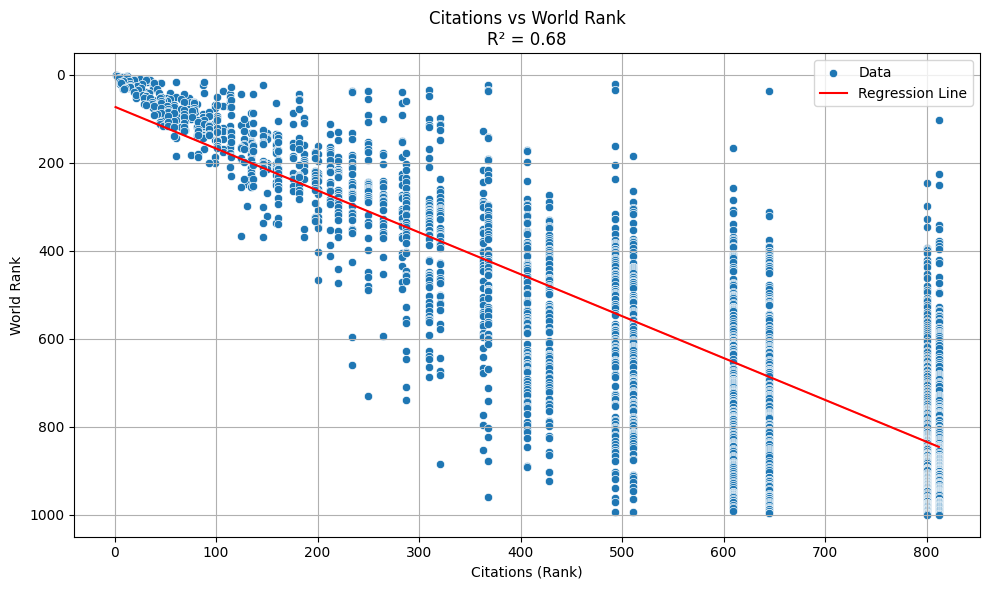

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='citations', y='world_rank', data=cwur_df, label='Data')
sns.lineplot(x=cwur_df['citations'], y=y_pred, color='red', label='Regression Line')
plt.gca().invert_yaxis()  # 排名越小越好
plt.title(f'Citations vs World Rank\nR² = {r2:.2f}')
plt.xlabel('Citations (Rank)')
plt.ylabel('World Rank')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Baseline univariate model: using only citations
y = cwur_df['world_rank']
X_base = sm.add_constant(cwur_df[['citations']])
model_base = sm.OLS(y, X_base).fit()
r2_base = model_base.rsquared

# Try adding other variables to identify the one that increases R² the most.
candidate_vars = [
    'quality_of_faculty', 'alumni_employment', 'patents',
    'publications', 'influence', 'broad_impact', 'quality_of_education',
    'national_rank'
]
r2_gains = []

for var in candidate_vars:
    X = sm.add_constant(cwur_df[['citations', var]])
    model = sm.OLS(y, X).fit()
    r2_gain = model.rsquared - r2_base
    r2_gains.append((var, r2_gain))

# Sort and convert into a data table.
r2_gains_sorted = sorted(r2_gains, key=lambda x: x[1], reverse=True)
df_r2_gains = pd.DataFrame(r2_gains_sorted, columns=['Variable', 'R² Gain'])

print(df_r2_gains)

               Variable   R² Gain
0          broad_impact  0.210599
1          publications  0.172118
2             influence  0.122170
3               patents  0.060609
4     alumni_employment  0.059113
5  quality_of_education  0.032573
6    quality_of_faculty  0.018750
7         national_rank  0.006948


## 2. 哪個指標最影響世界排名
- 問題說明：教學品質、師資、引用量、專利，誰最影響排名？
- 分析方法：關係性分析（關係權重）

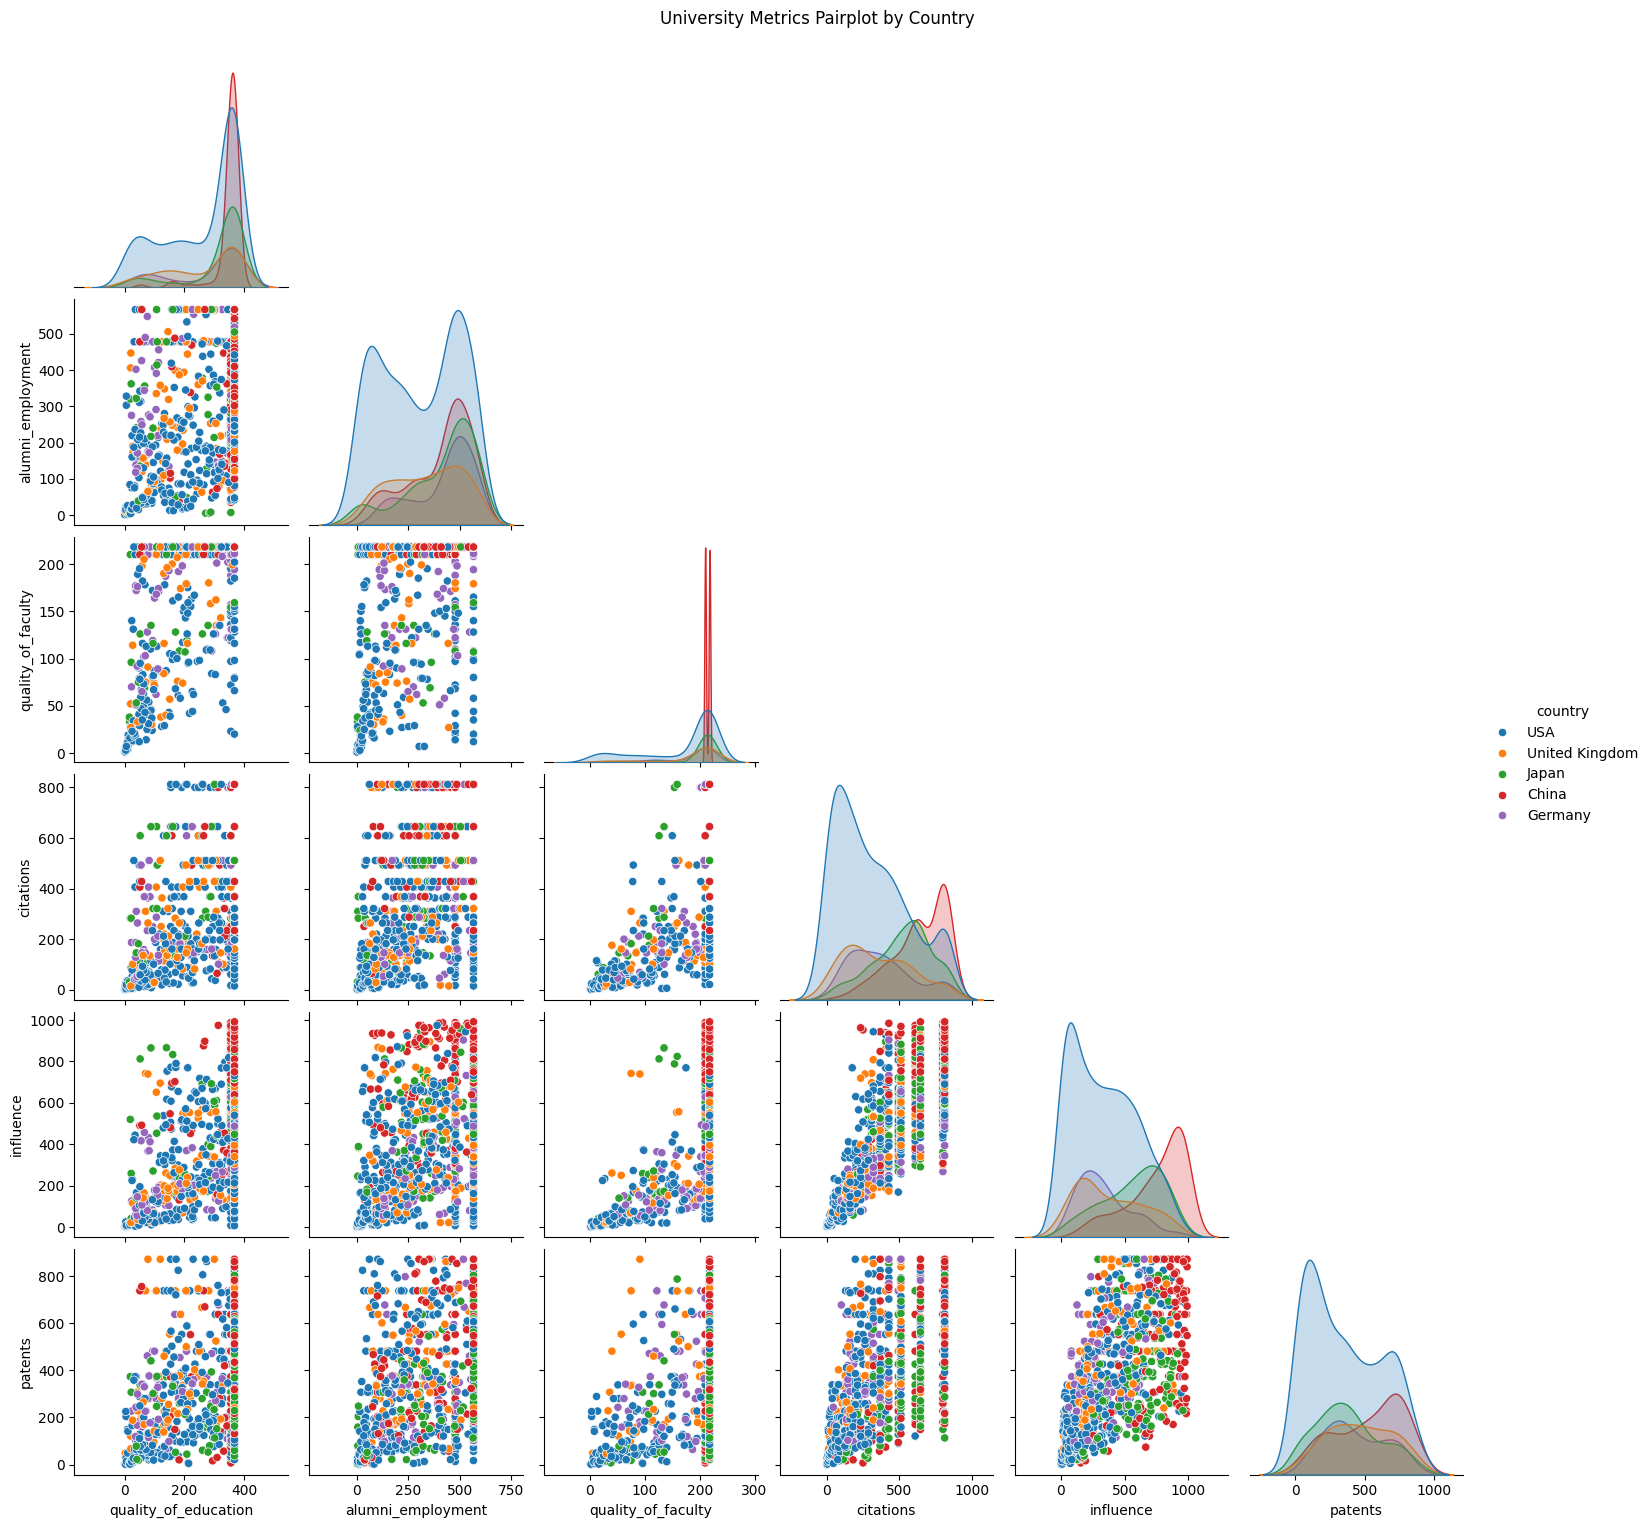

In [ ]:
# Select the indicators to analyze and limit to the top 30 countries (to avoid too many colors).
top_countries = cwur_df['country'].value_counts().head(5).index.tolist()
filtered_df = cwur_df[cwur_df['country'].isin(top_countries)]

# Select the required columns and set the HUE.
selected_cols = ['quality_of_education', 'alumni_employment', 'quality_of_faculty', 'citations', 'influence', 'patents', 'country']

# Keep only the data for the selected columns.
plot_df = filtered_df[selected_cols].dropna()

# Plot the pairplot
sns.pairplot(plot_df, hue='country', corner=True)
plt.suptitle("University Metrics Pairplot by Country", y=1.02)
plt.show()


## 3. 校友就業力是否推動得分？
- 問題說明：有高就業力的學校，是否得分也會高？
- 分析方法：相關性分析 + 回歸

Index(['world_rank', 'institution', 'country', 'national_rank',
       'quality_of_education', 'alumni_employment', 'quality_of_faculty',
       'publications', 'influence', 'citations', 'broad_impact', 'patents',
       'score', 'year'],
      dtype='object')
       alumni_employment        score
count        2000.000000  2000.000000
mean          385.263500    47.067630
std           171.874782     6.590461
min             1.000000    44.020000
25%           250.750000    44.440000
50%           478.000000    44.960000
75%           500.250000    46.812500
max           567.000000   100.000000


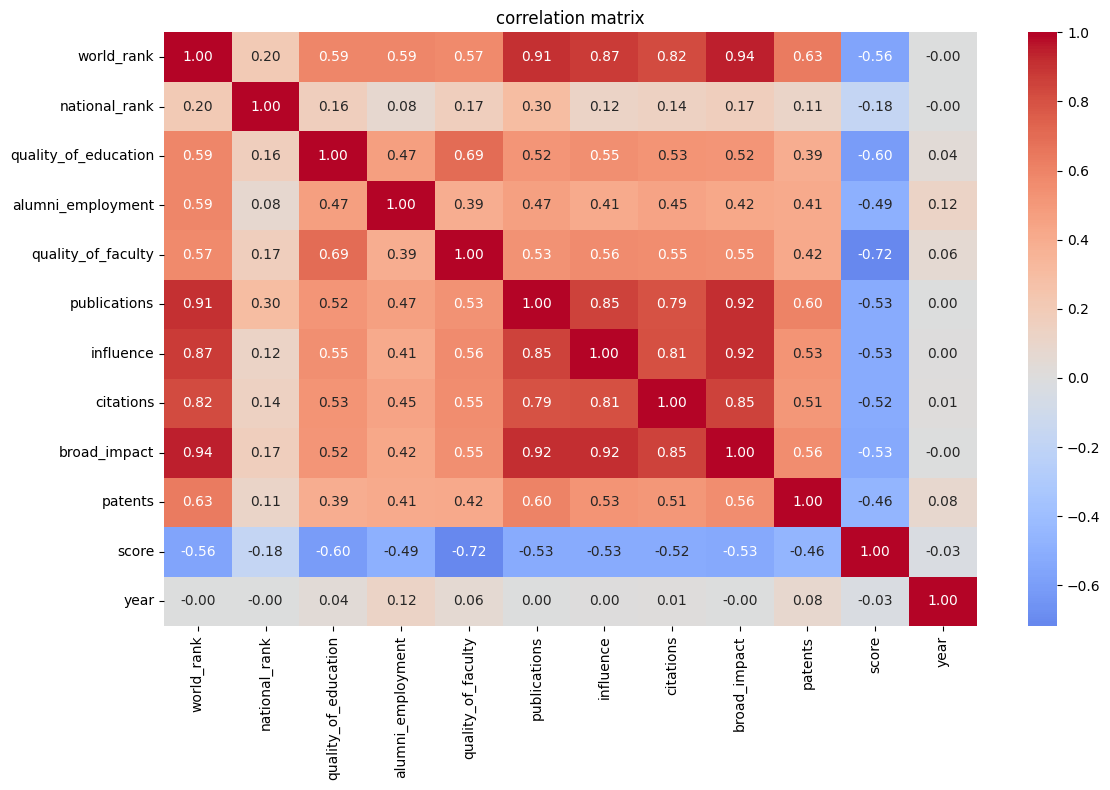


 multivariate linear regression analysis result:
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     408.8
Date:                Thu, 29 May 2025   Prob (F-statistic):               0.00
Time:                        14:27:11   Log-Likelihood:                -5718.1
No. Observations:                2000   AIC:                         1.145e+04
Df Residuals:                    1992   BIC:                         1.150e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

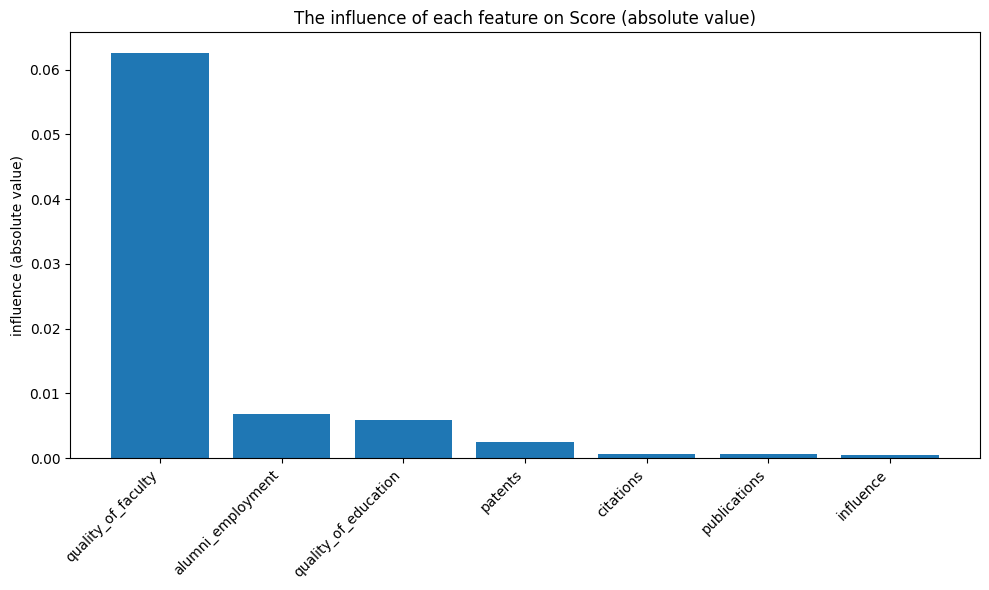


各特徵的影響程度 (按絕對值排序)：
quality_of_faculty: -0.063 (絕對值: 0.063)
alumni_employment: -0.007 (絕對值: 0.007)
quality_of_education: -0.006 (絕對值: 0.006)
patents: -0.003 (絕對值: 0.003)
citations: -0.001 (絕對值: 0.001)
publications: -0.001 (絕對值: 0.001)
influence: -0.000 (絕對值: 0.000)


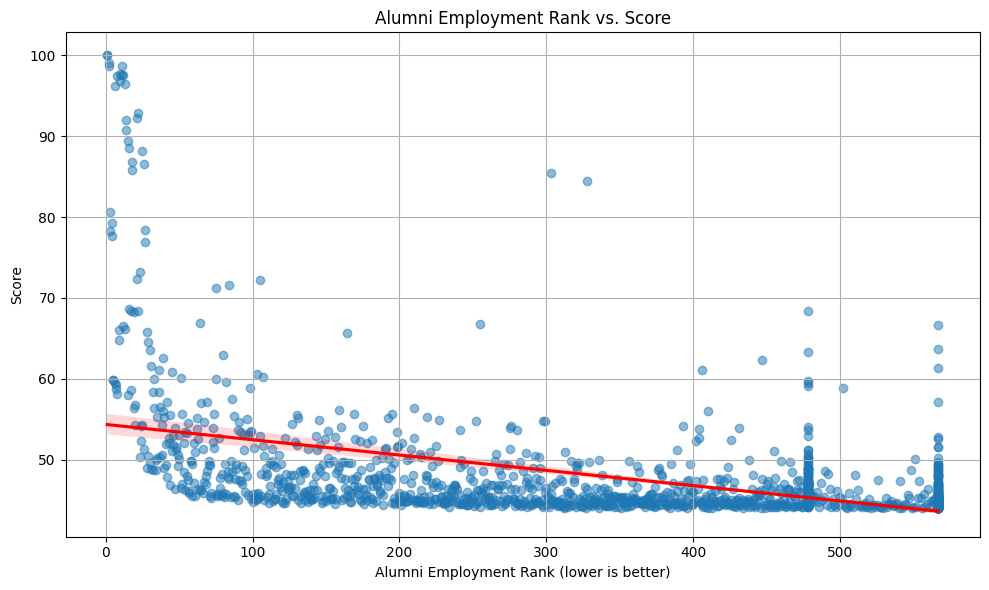

皮爾森相關係數: 87.933
p-value: 0.00000


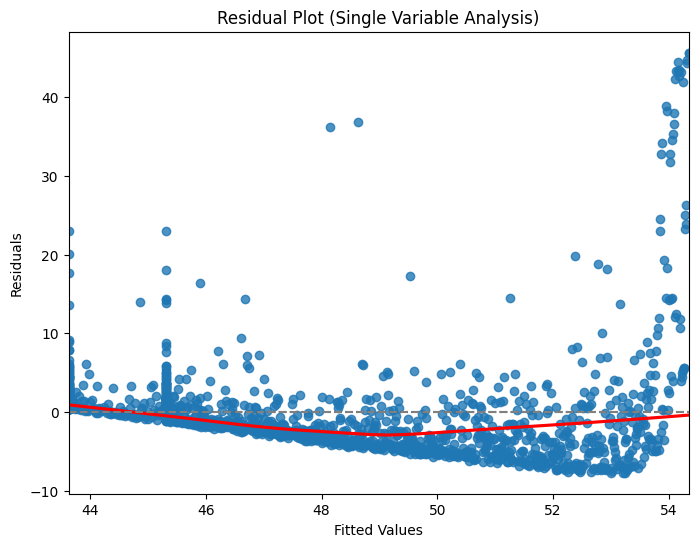

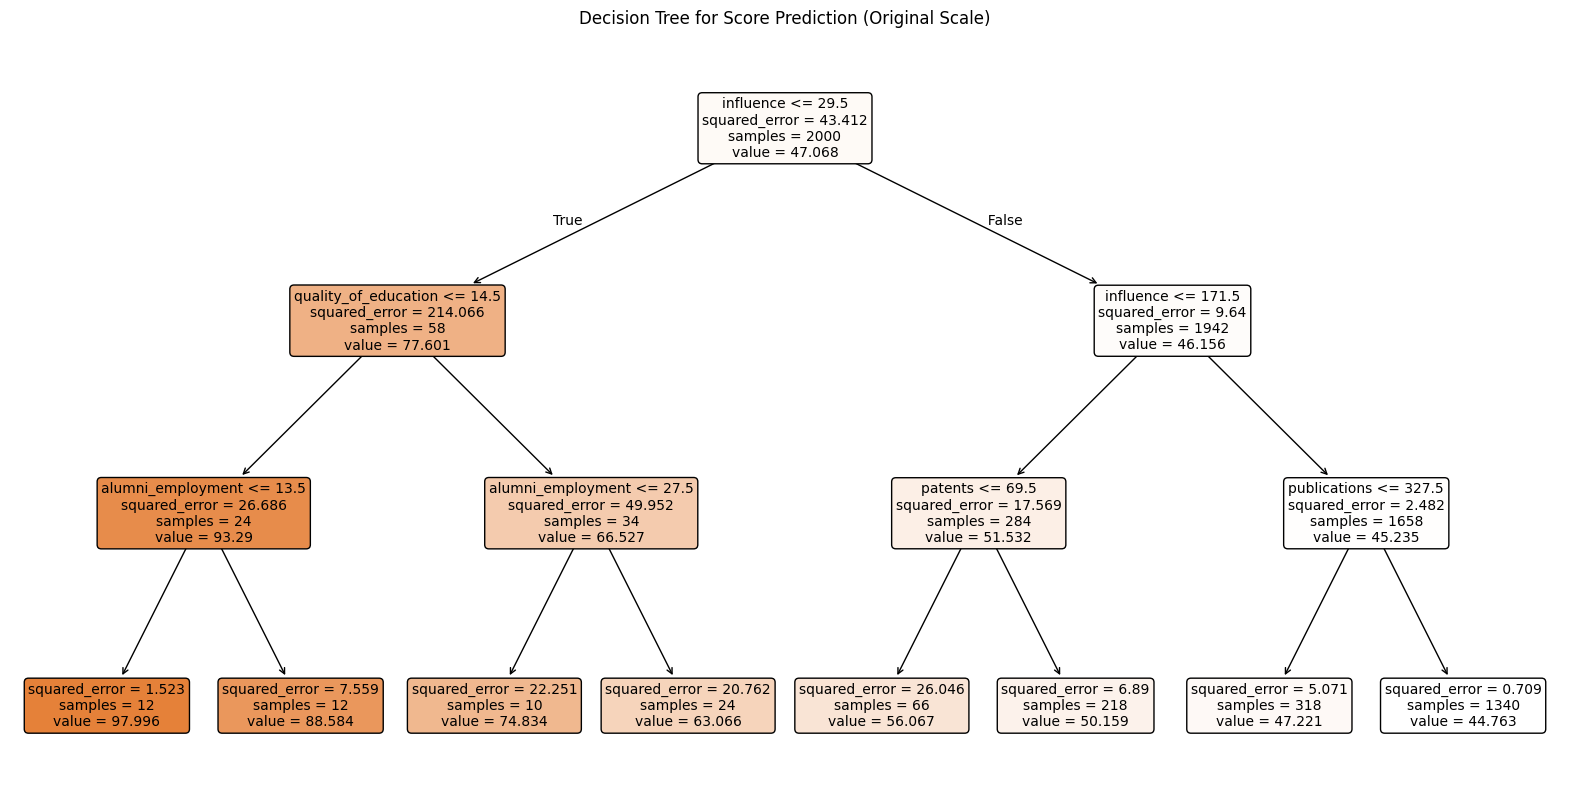

In [ ]:
# Check the columns and data.
print(cwur_df.columns)
print(cwur_df[['alumni_employment', 'score']].describe())

# Select the features to analyze.
features = ['quality_of_education', 'quality_of_faculty', 'alumni_employment',
           'publications', 'influence', 'citations', 'patents', 'score']

# Calculate the correlation matrix.
correlation_matrix = cwur_df[features].corr()

df_filtered = cwur_df[cwur_df['year'].isin([2014, 2015])]
numeric_df = df_filtered.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('correlation matrix')
plt.tight_layout()
plt.show()

# All features except for the score.
X = cwur_df[features[:-1]]
y = cwur_df['score']

# Add the intercept term
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("\n multivariate linear regression analysis result:")
print(model.summary())


plt.figure(figsize=(10, 6))
coef = pd.DataFrame({
    '特徵': features[:-1],
    '係數': model.params[1:],
    '絕對值': abs(model.params[1:]),
    'P值': model.pvalues[1:]
})

# Sort by the absolute value magnitude.
coef = coef.sort_values('絕對值', ascending=False)

plt.bar(coef['特徵'], coef['絕對值'])
plt.xticks(rotation=45, ha='right')
plt.title('The influence of each feature on Score (absolute value)')
plt.ylabel('influence (absolute value)')
plt.tight_layout()
# plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed impact levels
print("\n各特徵的影響程度 (按絕對值排序)：")
for _, row in coef.iterrows():
    print(f"{row['特徵']}: {row['係數']:.3f} (絕對值: {row['絕對值']:.3f})")


plt.figure(figsize=(10, 6))
sns.regplot(x='alumni_employment', y='score', data=cwur_df, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title('Alumni Employment Rank vs. Score')
plt.xlabel('Alumni Employment Rank (lower is better)')
plt.ylabel('Score')
plt.grid(True)
plt.tight_layout()
# plt.savefig('alumni_employment_vs_score.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate the Pearson correlation coefficient
corr, p_value = ttest_ind(cwur_df['alumni_employment'], cwur_df['score'])
print(f'皮爾森相關係數: {corr:.3f}')
print(f'p-value: {p_value:.5f}')

# Univariate linear regression
X_single = cwur_df['alumni_employment']
y = cwur_df['score']
X_single = sm.add_constant(X_single)
model_single = sm.OLS(y, X_single).fit()

# Plot the residual plot for the univariate analysis
fig = plt.figure(figsize=(8, 6))
residuals = model_single.resid
fitted = model_single.fittedvalues
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={"color": "red"})
plt.title('Residual Plot (Single Variable Analysis)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(0, linestyle='--', color='gray')
# plt.savefig('residual_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. Decision tree visualization

X = cwur_df[features[:-1]]
y = cwur_df['score']

# Train the decision tree
dt = DecisionTreeRegressor(max_depth=3, random_state=42)
dt.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=features[:-1], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree for Score Prediction (Original Scale)')
# plt.savefig('decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. 國家隊排名的影響力
- 問題說明：檢視國內排名與全球排名之間的關聯，並評估各國頂尖的國立大學
- 分析方法:  data manipulation and visualization

Grouped Statistics by National Rank:
   national_rank        mean  median  min  max  count
0              1  348.444444   278.0    1  986    117
1              2  344.450549   267.0    2  987     91
2              3  392.243902   336.5    3  988     82
3              4  420.605263   401.0    6  997     76
4              5  434.594203   425.0    7  985     69
5              6  437.716667   388.5    8  959     60
6              7  448.648148   325.5    9  996     54
7              8  469.187500   362.5   10  993     48
8              9  466.340909   398.5   11  964     44
9             10  437.684211   379.0   12  954     38


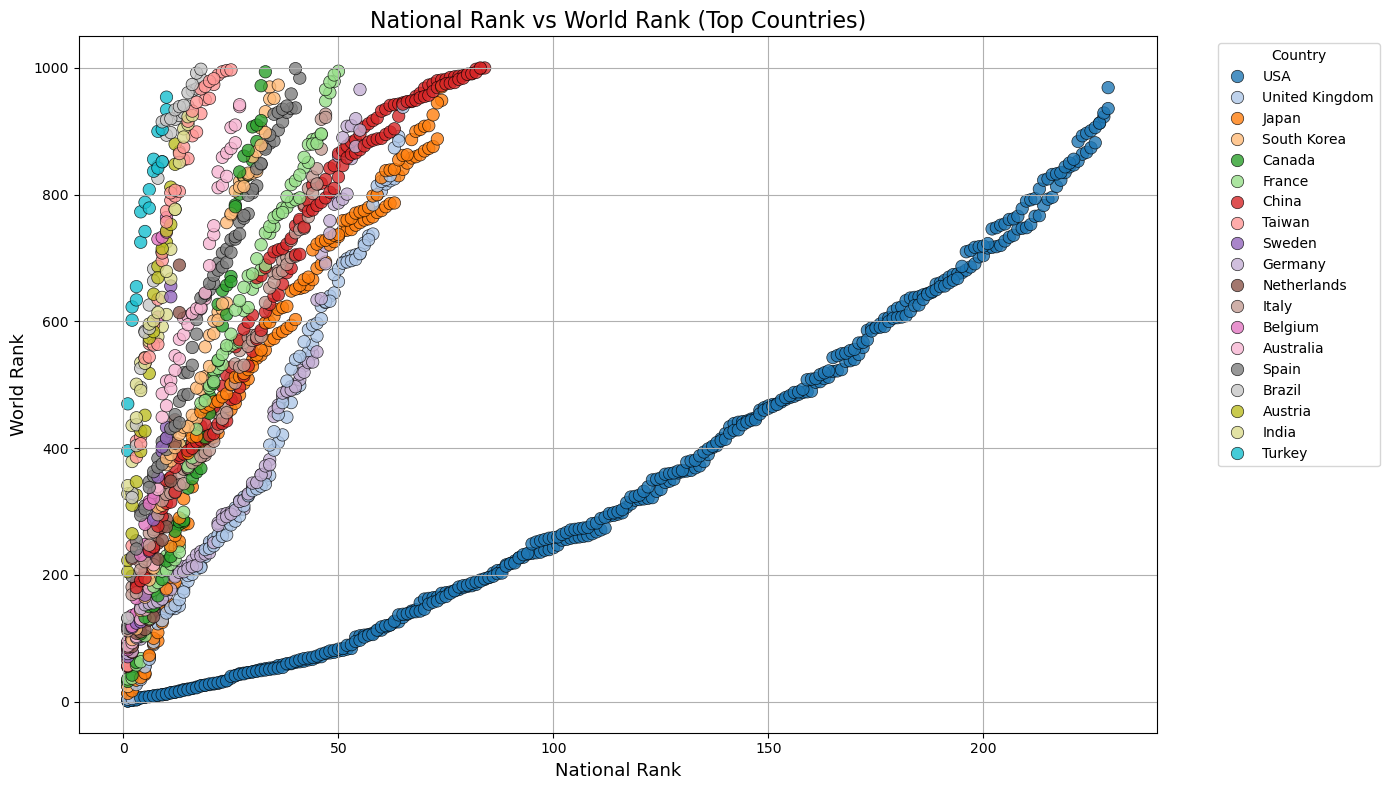

In [4]:
cwur_df[['world_rank', 'national_rank']] = cwur_df[['world_rank', 'national_rank']].apply(pd.to_numeric, errors='coerce')
cwur_df.dropna(subset=['world_rank', 'national_rank'], inplace=True)

# Group statistics by national_rank
grouped_stats = cwur_df.groupby('national_rank')['world_rank'].agg(['mean', 'median', 'min', 'max', 'count']).reset_index()
print("Grouped Statistics by National Rank:")
print(grouped_stats.head(10))

grouped_stats.to_csv("national_rank_grouped_world_rank_summary.csv", index=False)

# Filter top countries with most universities
top_countries = cwur_df['country'].value_counts().loc[lambda x: x >= 20].index
df_filtered = cwur_df[cwur_df['country'].isin(top_countries)]

# Define color palette and create scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_filtered, x='national_rank', y='world_rank', hue='country',
                palette=sns.color_palette("tab20", len(top_countries)), alpha=0.8,
                edgecolor='black', linewidth=0.5, s=80)

plt.title('National Rank vs World Rank (Top Countries)', fontsize=16)
plt.xlabel('National Rank', fontsize=13)
plt.ylabel('World Rank', fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Country')
plt.grid(True)
plt.tight_layout()
plt.savefig("top_countries1.png")
plt.show()

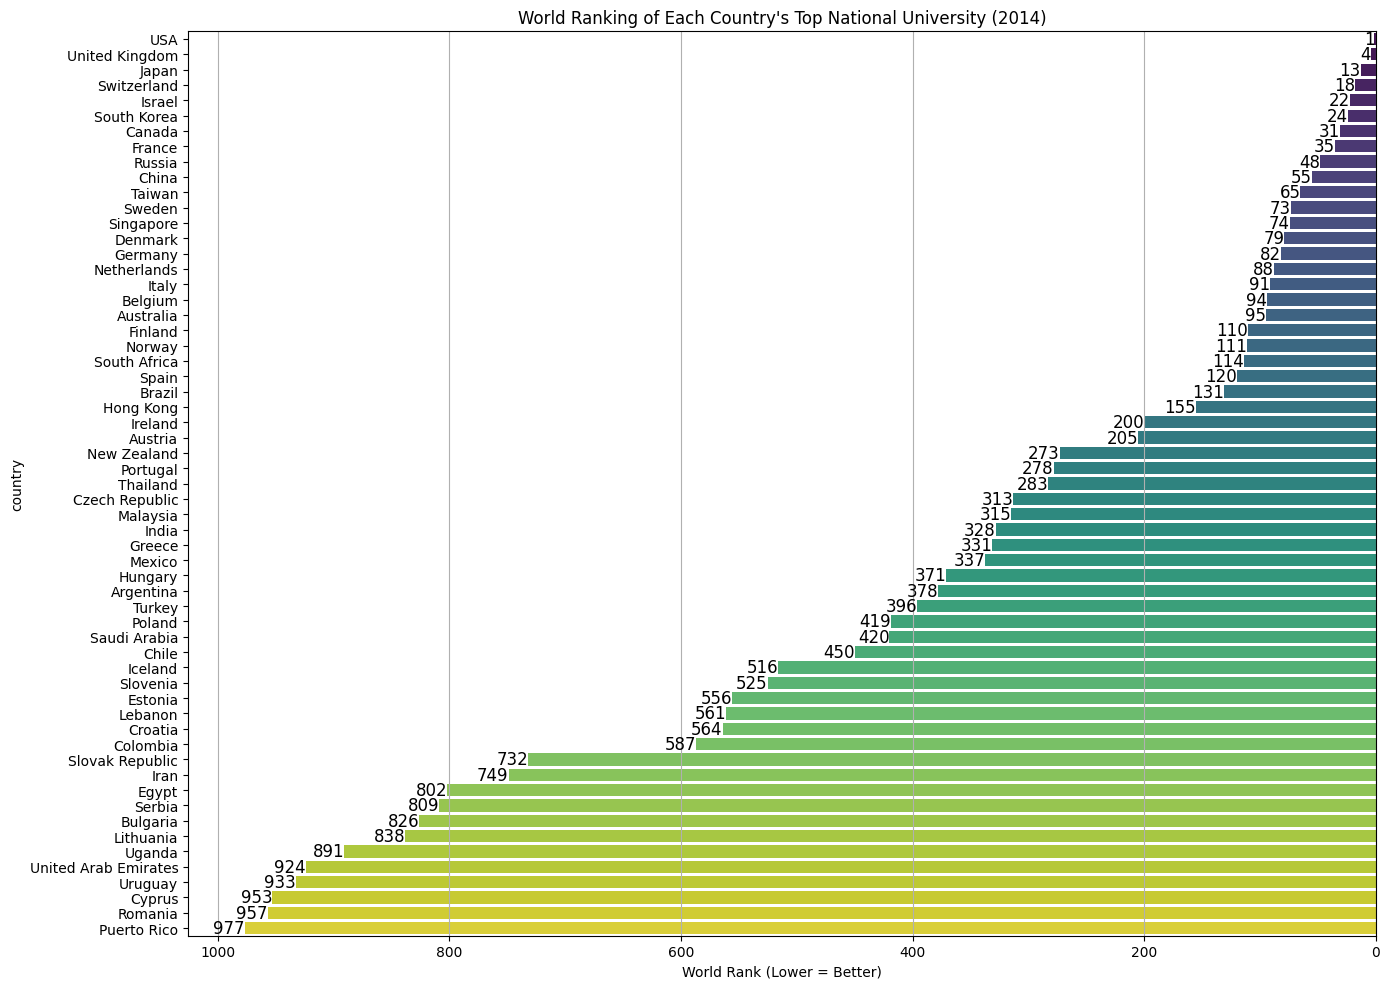

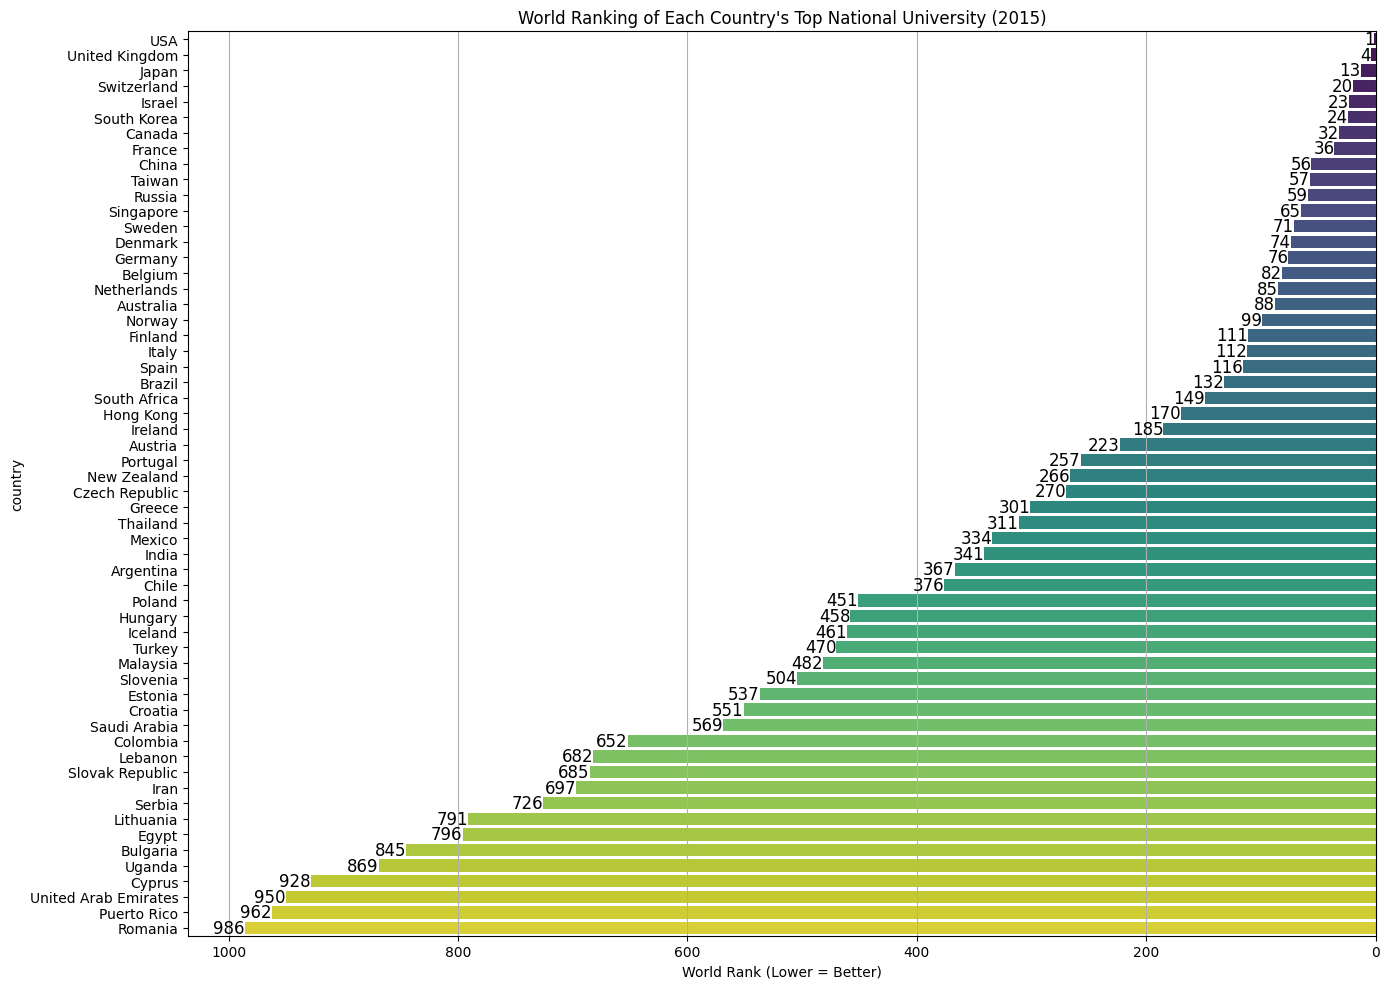

Top National Universities (2014):

             country                                     institution  world_rank  score
                 USA                              Harvard University           1 100.00
      United Kingdom                         University of Cambridge           4  97.64
               Japan                             University of Tokyo          13  80.64
         Switzerland Swiss Federal Institute of Technology in Zurich          18  72.18
              Israel                  Hebrew University of Jerusalem          22  66.76
         South Korea                       Seoul National University          24  66.06
              Canada                           University of Toronto          31  60.87
              France                École normale supérieure - Paris          35  59.72
              Russia               Lomonosov Moscow State University          48  56.42
               China                               Peking University          55  55.

In [ ]:
# Ensure columns are numeric
cwur_df["national_rank"] = pd.to_numeric(cwur_df["national_rank"], errors="coerce")
cwur_df["world_rank"] = pd.to_numeric(cwur_df["world_rank"], errors="coerce")

# Split into two groups based on the 'year' column
df_2014 = cwur_df[cwur_df["year"] == 2014]
df_2015 = cwur_df[cwur_df["year"] == 2015]

# Filter: Only national rank 1 universities for each year
top_national_2014 = df_2014[df_2014["national_rank"] == 1].dropna(subset=["world_rank", "country", "institution"])
top_national_2015 = df_2015[df_2015["national_rank"] == 1].dropna(subset=["world_rank", "country", "institution"])

# Sort by world rank
top_national_2014 = top_national_2014.sort_values("world_rank")
top_national_2015 = top_national_2015.sort_values("world_rank")

# Save 2014 chart
fig1, ax1 = plt.subplots(figsize=(14, 10))
sns.barplot(data=top_national_2014, x="world_rank", y="country", hue="country", palette="viridis", legend=False, ax=ax1)
ax1.set_title("World Ranking of Each Country's Top National University (2014)")
ax1.invert_xaxis()
ax1.set_xlabel("World Rank (Lower = Better)")
ax1.grid(axis='x')

for bar, (index, row) in zip(ax1.patches, top_national_2014.iterrows()):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{int(row["world_rank"])}',
             ha='right', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()
plt.savefig("2014.png", dpi=300)
plt.close()

# Save 2015 chart
fig2, ax2 = plt.subplots(figsize=(14, 10))
sns.barplot(data=top_national_2015, x="world_rank", y="country", hue="country", palette="viridis", legend=False, ax=ax2)
ax2.set_title("World Ranking of Each Country's Top National University (2015)")
ax2.invert_xaxis()
ax2.set_xlabel("World Rank (Lower = Better)")
ax2.grid(axis='x')

for bar, (index, row) in zip(ax2.patches, top_national_2015.iterrows()):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{int(row["world_rank"])}',
             ha='right', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()
plt.savefig("2015.png", dpi=300)
plt.close()

# Print summary tables
print("Top National Universities (2014):\n")
print(top_national_2014[["country", "institution", "world_rank", "score"]].to_string(index=False))

print("\nTop National Universities (2015):\n")
print(top_national_2015[["country", "institution", "world_rank", "score"]].to_string(index=False))

## 5. 高專利產出 vs 高學術影響力大學比較
- 問題說明：多專利的大學和多引用的大學，誰的排名高？
- 分析方法：分組比較

In [ ]:
# Select the top 25% of schools.
quantile = 0.25

In [ ]:
# Display statistical analysis.

def print_ttest(df, year):
    rank_patents = df[(df['year'] == str(year)) & (df['type'] == 'Patents')]['world_rank']
    rank_citations = df[(df['year'] == str(year)) & (df['type'] == 'Citations')]['world_rank']
    t_stat, p_val = ttest_ind(rank_patents, rank_citations)
    print(f"==== {year} 年資料分析 ====")
    print("Patents 平均排名：", rank_patents.mean())
    print("Citations 平均排名：", rank_citations.mean())
    print(f"t 統計量: {t_stat:.3f}")
    print(f"p 值: {p_val:.5f}\n")

==== 2014 年資料分析 ====
Patents 平均排名： 687.9848484848485
Citations 平均排名： 736.0127551020408
t 統計量: -2.882
p 值: 0.00408

==== 2015 年資料分析 ====
Patents 平均排名： 694.8452380952381
Citations 平均排名： 741.9522471910112
t 統計量: -2.763
p 值: 0.00590



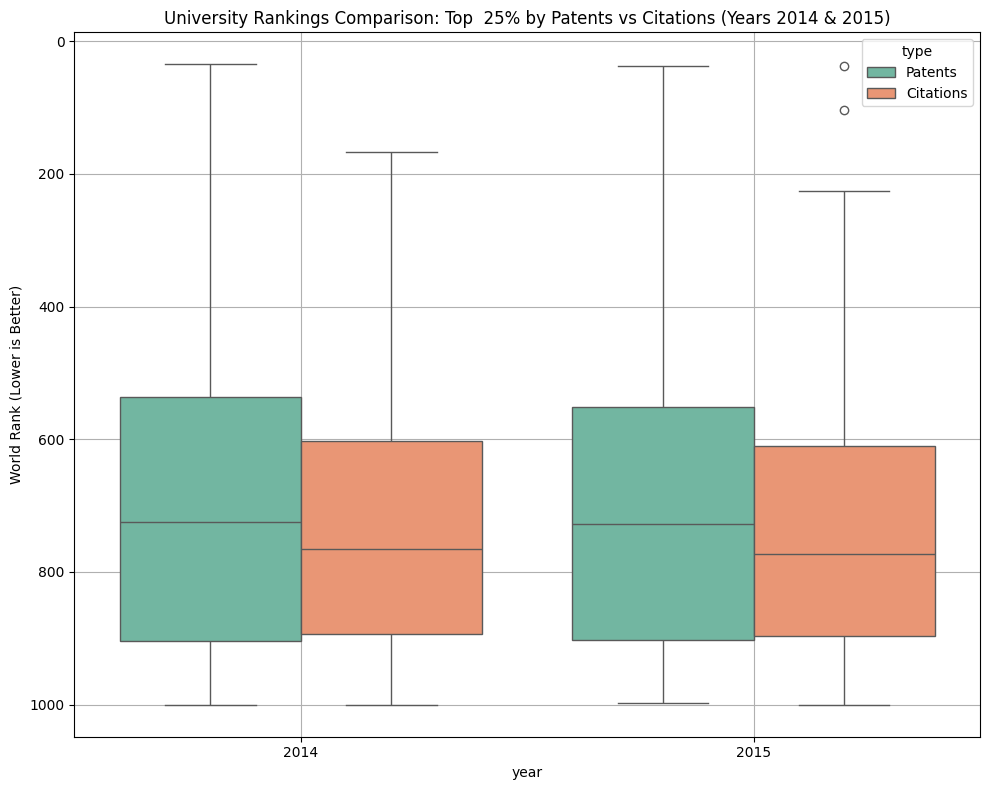

In [ ]:
group_list = []

for year in [2014, 2015]:
    for col, label in [('patents', 'Patents'), ('citations', 'Citations')]:

        # Extract the data for the specified year and sort by world_rank in ascending order
        year_df = cwur_df[cwur_df['year'] == year].sort_values(by='world_rank', ascending=True)

        # Calculate the top percentage for the given indicator.
        threshold = year_df[col].quantile(1 - quantile)

        # Filter schools with indicator values in the top percentage.
        top_col_df = year_df[year_df[col] >= threshold]

        group = pd.DataFrame({
            'world_rank': top_col_df['world_rank'],
            'type': label,
            'year': str(year)
        })
        group_list.append(group)

# Merge all data

combined_df = pd.concat(group_list, ignore_index=True)

# Output results: iterate through the years 2014 and 2015 and call the print\_ttest function to perform t-test
for year in [2014, 2015]:
    print_ttest(combined_df, year)

# Plot a multi-level labeled chart using year and type as the x-axis
plt.figure(figsize=(10, 8), dpi=100)
sns.boxplot(data=combined_df, x='year', y='world_rank', hue='type', palette="Set2")
plt.ylabel('World Rank (Lower is Better)')
plt.title(f'University Rankings Comparison: Top {quantile*100: .0f}% by Patents vs Citations (Years 2014 & 2015)')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. 學術 vs 創新型大學的分類
- 問題說明：根據論文引用、專利將大學分類
- 分析方法：分群 (Clustering)

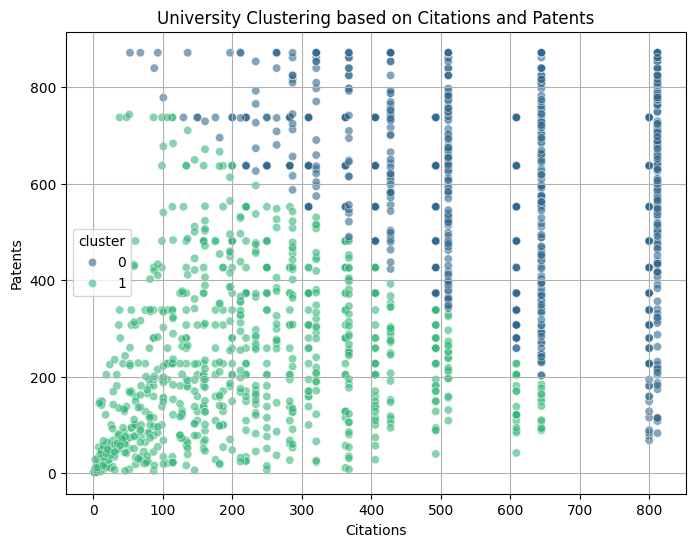


Cluster Centers (Scaled Data):
[[ 0.60682814  0.6165761 ]
 [-0.88049573 -0.89463983]]

Cluster Centers (Original Scale):
[[601.09628378 630.3597973 ]
 [229.14828431 238.10784314]]

Cluster 0 Statistics:
         citations      patents
count  1182.000000  1182.000000
mean    601.530457   630.571066
std     178.692007   180.381789
min      53.000000    68.000000
25%     493.000000   517.250000
50%     609.000000   660.500000
75%     800.000000   737.000000
max     812.000000   871.000000

Cluster 1 Statistics:
        citations     patents
count  818.000000  818.000000
mean   229.430318  238.761614
std    158.142045  164.475326
min      1.000000    1.000000
25%    101.000000  102.250000
50%    200.000000  206.500000
75%    321.000000  347.500000
max    645.000000  743.000000


In [ ]:
# Selecting relevant columns for clustering
clustering_data = cwur_df[['citations', 'patents']].dropna()

# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Applying K-Means Clustering
# Let's try 2 clusters first (Academic vs Innovative)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10) # Explicitly set n_init
clustering_data['cluster'] = kmeans.fit_predict(scaled_data)

# Visualizing the clusters
plt.figure(figsize=(8, 6), dpi=100)
sns.scatterplot(data=clustering_data, x='citations', y='patents', hue='cluster', palette='viridis', alpha=0.6)
plt.xlabel('Citations')
plt.ylabel('Patents')
plt.title('University Clustering based on Citations and Patents')
plt.grid(True)
plt.show()

# Displaying the characteristics of each cluster (optional)
print("\nCluster Centers (Scaled Data):")
print(kmeans.cluster_centers_)

print("\nCluster Centers (Original Scale):")
print(scaler.inverse_transform(kmeans.cluster_centers_))

# Analyze the characteristics of each cluster
print("\nCluster 0 Statistics:")
print(clustering_data[clustering_data['cluster'] == 0][['citations', 'patents']].describe())

print("\nCluster 1 Statistics:")
print(clustering_data[clustering_data['cluster'] == 1][['citations', 'patents']].describe())

<ipython-input-23-93e4f476d211>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.values, y=country_counts.index, palette="viridis")


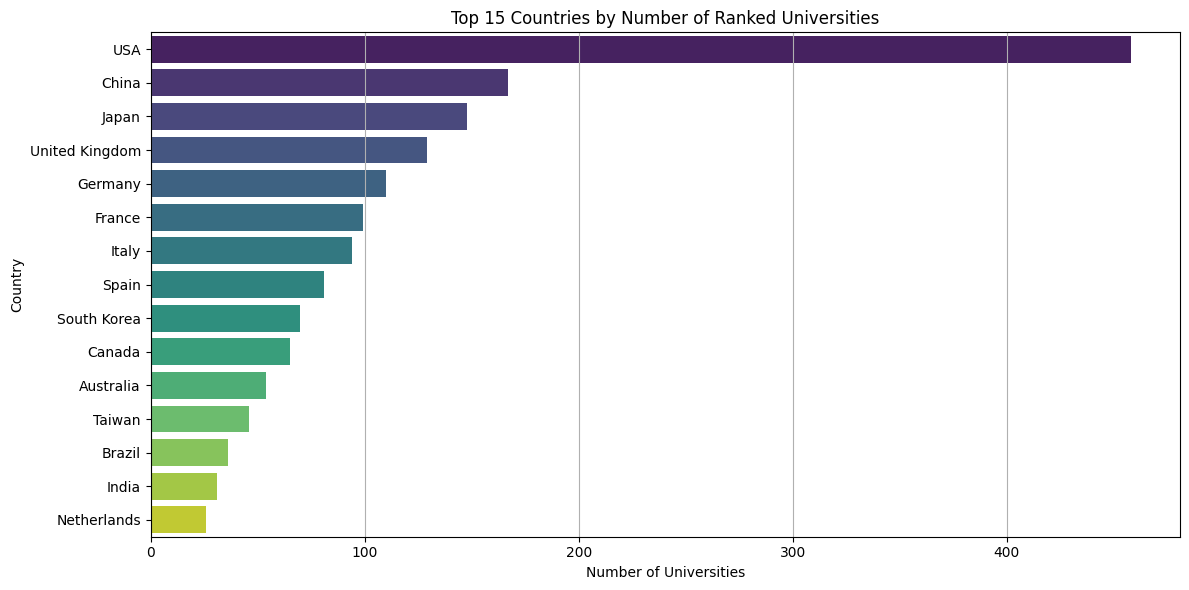

<ipython-input-23-93e4f476d211>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rank_by_country.values, y=avg_rank_by_country.index, palette="magma")


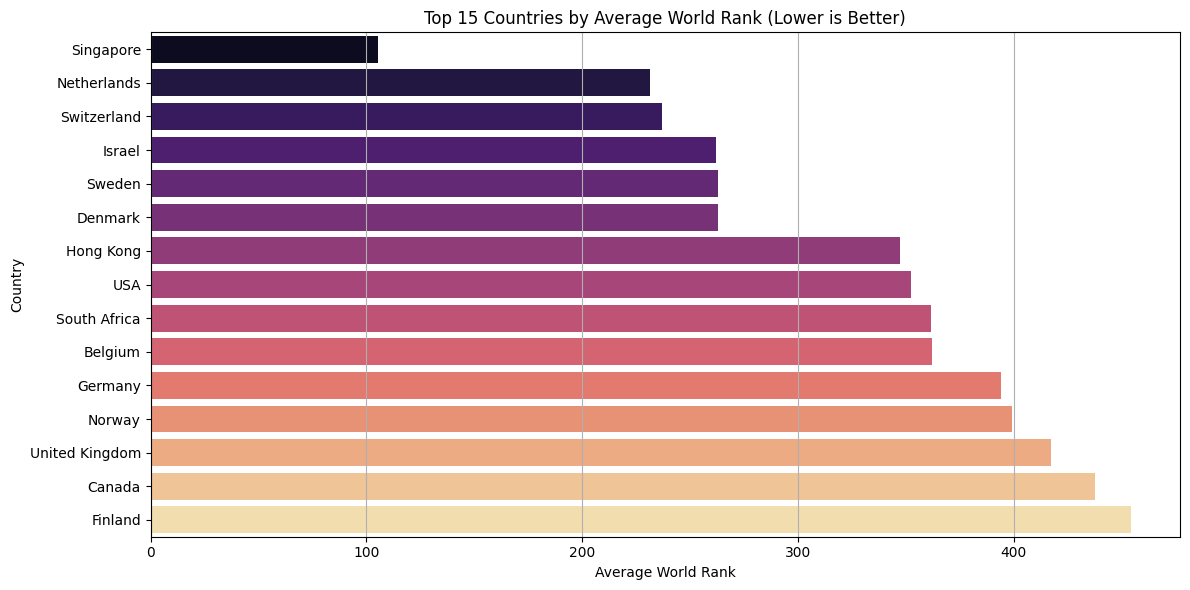

<ipython-input-23-93e4f476d211>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset_df, x='country', y='citations', palette='Set2')


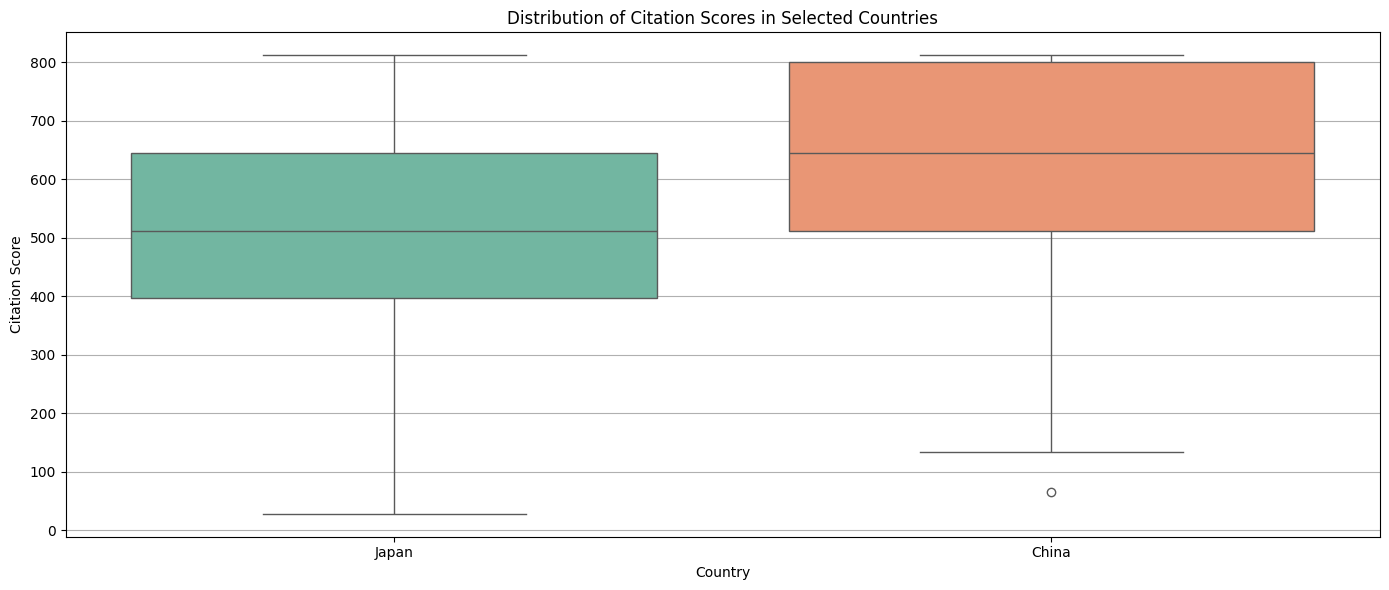

In [ ]:
# Convert ranking to numeric (in case of any non-numeric values)
cwur_df['world_rank'] = pd.to_numeric(cwur_df['world_rank'], errors='coerce')

# Top 15 countries by number of ranked universities
country_counts = cwur_df['country'].value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.values, y=country_counts.index, palette="viridis")
plt.title("Top 15 Countries by Number of Ranked Universities")
plt.xlabel("Number of Universities")
plt.ylabel("Country")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Average world rank by country (lower is better)
avg_rank_by_country = cwur_df.groupby("country")['world_rank'].mean().sort_values().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_rank_by_country.values, y=avg_rank_by_country.index, palette="magma")
plt.title("Top 15 Countries by Average World Rank (Lower is Better)")
plt.xlabel("Average World Rank")
plt.ylabel("Country")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Boxplot of citation scores for selected countries
selected_countries = ['United States', 'China', 'Japan']
subset_df = cwur_df[cwur_df['country'].isin(selected_countries)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=subset_df, x='country', y='citations', palette='Set2')
plt.title("Distribution of Citation Scores in Selected Countries")
plt.ylabel("Citation Score")
plt.xlabel("Country")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Bonus 1. 關鍵字整理
- 用途說明：專利前 10 名國家
- 分析方法：關鍵字雲

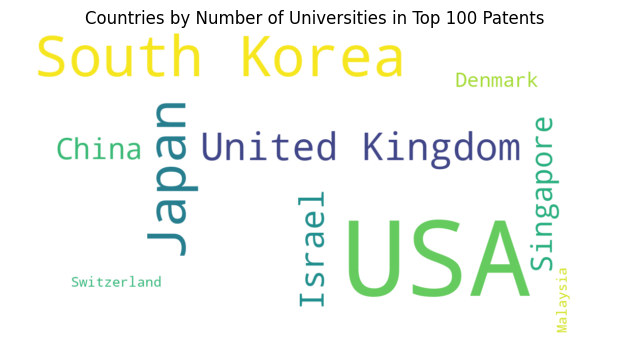

In [ ]:
top_100_by_citations = cwur_df.nsmallest(100, 'patents')
country_counts = top_100_by_citations['country'].value_counts()
# print(country_counts)

wordcloud = WordCloud(
    background_color='white',
    margin=0,
    scale=3,
    relative_scaling=0.6,
    prefer_horizontal=0.9,
    collocations=False
).generate_from_frequencies(country_counts)

# plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Countries by Number of Universities in Top 100 Patents")
plt.tight_layout()
plt.show()

## Bonus 2. 關鍵字整理
- 用途說明：引用量前 10 名國家
- 分析方法：關鍵字雲

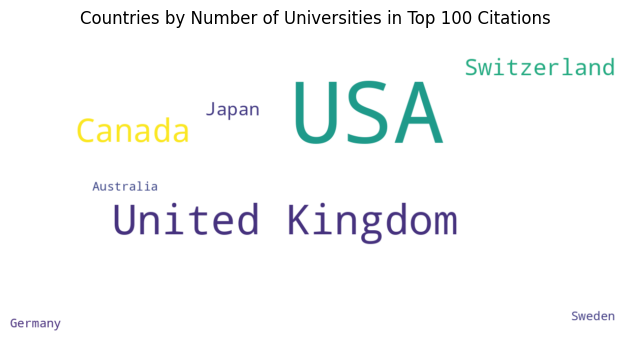

In [ ]:
top_100_by_citations = cwur_df.nsmallest(100, 'citations')
country_counts = top_100_by_citations['country'].value_counts()
# print(country_counts)

wordcloud = WordCloud(
    background_color='white',
    margin=0,
    scale=3,
    relative_scaling=0.6,
    prefer_horizontal=0.9,
    collocations=False
).generate_from_frequencies(country_counts)

# plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Countries by Number of Universities in Top 100 Citations")
plt.tight_layout()
plt.show()

## Bonus 3. 智慧問答
- 用途說明：取得前三名學校，並進行簡介或任意問答
- 分析方法：RAG + Wikipedia (Data Mining)

In [ ]:
top_universities = cwur_df['institution'].dropna().unique().tolist()[:3]

wikipedia.set_lang("en")  # 使用英文版 Wikipedia

def get_summary(name):
    try:
        return wikipedia.summary(name, sentences=3)
    except Exception as e:
        return f"Summary not available for {name}: {str(e)}"

# 建立資料集
# Prepare data in a format suitable for DataFrameLoader
data_for_loader = []
for uni in top_universities:
    summary = get_summary(uni)
    data_for_loader.append({"name": uni, "content": summary})

# Create a pandas DataFrame from the data
docs_df = pd.DataFrame(data_for_loader)

# Load the DataFrame into Langchain documents
# Using 'content' as the page_content_column and 'name' as metadata
loader = DataFrameLoader(docs_df, page_content_column="content")
langchain_docs = loader.load()

# Split documents (optional, but good practice for larger texts)
# text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
# split_docs = text_splitter.split_documents(langchain_docs)

# Define the embedding function
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Create the vector database using Chroma
# You can specify a directory for persistence if you want to save the database
# persist_directory = 'chroma_db'
# vectordb = Chroma.from_documents(documents=langchain_docs, # Use langchain_docs or split_docs
#                                  embedding=embeddings,
#                                  persist_directory=persist_directory)

# In-memory Chroma database for simplicity in this example
vectordb = Chroma.from_documents(documents=langchain_docs, # Use langchain_docs or split_docs
                                 embedding=embeddings)


query = "Which university focuses on technology?"
results = vectordb.similarity_search(query, k=5)

for r in results:
    print(f"🔸 {r.metadata['name']}")
    print(f"📘 {r.page_content}\n")

<ipython-input-10-5d294bc6359e>:31: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  wa

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🔸 Massachusetts Institute of Technology
📘 The Massachusetts Institute of Technology (MIT) is a private research university in Cambridge, Massachusetts, United States. Established in 1861, MIT has played a significant role in the development of many areas of modern technology and science.
In response to the increasing industrialization of the United States, William Barton Rogers organized a school in Boston to create "useful knowledge." Initially funded by a federal land grant, the institute adopted a polytechnic model that stressed laboratory instruction in applied science and engineering.

🔸 Harvard University
📘 Harvard University is a private Ivy League research university in Cambridge, Massachusetts, United States. Founded October 28, 1636, and named for its first benefactor, the Puritan clergyman John Harvard, it is the oldest institution of higher learning in the United States. Its influence, wealth, and rankings have made it one of the most prestigious universities in the world.


## Bonus 4. 翻譯工具
- 用途說明：將問答進行翻譯
- 執行方式：將Bonus 3的問題透過 API 翻譯

In [ ]:
import deepl

# 你的 DeepL API 金鑰（請用自己的金鑰替換）
DEEPL_API_KEY = "please-use-your-api-key"
translator = deepl.Translator(DEEPL_API_KEY)
try:
    translator = deepl.Translator(DEEPL_API_KEY)
    print("DeepL Translator 初始化成功。")

    # 原始查詢（英文）
    query = "Which university focuses on technology?"

    # 翻譯原始查詢成中文 (這部分已經存在)
    translation = translator.translate_text(query, target_lang="ZH-HANT")
    print("📥 原始查詢（英文）:")
    print(query)
    print("\n🌏 翻譯查詢（中文）:")
    print(translation.text)

    # 相似度檢索 (使用原始英文查詢進行檢索，因為 vectordb 是用英文內容建立的)
    print("\n🔎 相似度檢索結果：\n")

    # 請確認 vectordb 在此之前已成功建立 (位於前一個 Cell)
    # 如果因 DeepL 錯誤導致執行中斷，vectordb 可能尚未準備好
    try:
        results = vectordb.similarity_search(query, k=3) # 這裡仍使用原始英文查詢
        print("找到相似結果。")
        for r in results:
            # 翻譯大學名稱
            try:
                translated_name = translator.translate_text(r.metadata['name'], target_lang="ZH-HANT").text
            except Exception as e:
                translated_name = f"翻譯名稱失敗: {e}"
                print(f"警告: 翻譯名稱 '{r.metadata['name']}' 時發生錯誤: {e}")

            # 翻譯摘要內容
            try:
                translated_content = translator.translate_text(r.page_content, target_lang="ZH-HANT").text
            except Exception as e:
                translated_content = f"翻譯內容失敗: {e}"
                print(f"警告: 翻譯內容時發生錯誤: {e}")


            print(f"🔸 大學名稱: {r.metadata['name']}")
            print(f"   (中文翻譯: {translated_name})") # 顯示翻譯後的名稱
            print(f"📘 摘要內容:")
            print(r.page_content)
            print(f"   (中文翻譯: {translated_content})\n") # 顯示翻譯後的內容

    except NameError:
        print("錯誤: vectordb 未定義。請確認之前的 Chroma 向量索引建立步驟已成功執行。")
    except Exception as e:
         print(f"檢索或處理結果時發生錯誤: {e}")


except deepl.exceptions.AuthorizationException as e:
    print(f"DeepL 授權錯誤: {e}")
    print("請檢查你的 DeepL API 金鑰是否正確且有效。")
except Exception as e:
    print(f"DeepL 初始化或翻譯時發生其他錯誤: {e}")

DeepL Translator 初始化成功。
📥 原始查詢（英文）:
Which university focuses on technology?

🌏 翻譯查詢（中文）:
哪所大學專注於科技？

🔎 相似度檢索結果：

找到相似結果。
🔸 大學名稱: Massachusetts Institute of Technology
   (中文翻譯: 麻省理工學院)
📘 摘要內容:
The Massachusetts Institute of Technology (MIT) is a private research university in Cambridge, Massachusetts, United States. Established in 1861, MIT has played a significant role in the development of many areas of modern technology and science.
In response to the increasing industrialization of the United States, William Barton Rogers organized a school in Boston to create "useful knowledge." Initially funded by a federal land grant, the institute adopted a polytechnic model that stressed laboratory instruction in applied science and engineering.
   (中文翻譯: 麻省理工學院 (MIT) 是一所私立研究型大學，位於美國麻省劍橋市。麻省理工學院成立於 1861 年，在現代技術和科學的許多領域的發展中扮演了重要的角色。
為了因應美國日益增長的工業化，William Barton Rogers 在波士頓組織了一所學校，以創造 「有用的知識」。該學院最初由聯邦土地補助金資助，採用理工學院模式，強調應用科學與工程的實驗室教學。)

🔸 大學名稱: Harvard University
   (中文翻譯: 哈佛大學)
📘 摘要內容:
Harvard 

## Bonus 5. 散佈矩陣圖
- 用途說明：可視化多個變數之間的兩兩關係與分布情形

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 讀入資料
df = pd.read_csv(file_path)

# 選取想分析的指標 + 限制前30名國家（以免顏色過多）
top_countries = df['country'].value_counts().head(5).index.tolist()
filtered_df = df[df['country'].isin(top_countries)]

# 選擇需要的欄位 + hue
selected_cols = ['quality_of_education', 'alumni_employment', 'quality_of_faculty', 'citations', 'influence', 'patents', 'country']

# 只保留選擇欄位的資料
plot_df = filtered_df[selected_cols].dropna()

# 繪製 pairplot
sns.pairplot(plot_df, hue='country', corner=True)
plt.suptitle("University Metrics Pairplot by Country", y=1.02)
plt.show()
